# Introduction to Data Science and Systems 2021-2022<small><small>v20212022a</small></small>
## Lab 4: Data Science in practice
#### - ***you should submit this notebook on Moodle along with one pdf file (see the end of the notebook and Moodle for instructions)***
---
#### University of Glasgow


$$
\newcommand{\vec}[1]{ {\bf #1}} 
\newcommand{\real}{\mathbb{R}}
\DeclareMathOperator*{\argmin}{arg\,min}
\newcommand{\expect}[1]{\mathbb{E}[#1]}
$$

## Purpose of this lab

In the lab you will apply some of the data science and systems techniques you have learned about previously. The aim is to use the basic techniques to solve a specific problem related to accessing and storing data in a Panda dataframe. 

#### Part 1:
* revisit how to use Pandas to easily load and inspect a dataset 

#### Part 2:
* implement a solution for compressing the values in the dataset based on PCA

####  Part 3:
* investigate the relationship between query cardinality and the query itself
* sample a set of realistic queries using your knowledge of probability density functions
* collect a dataset of queries and cardinality using Pandas 
* suggest and implement your own solution for predicting the cardinality of the query (using linear algebra)


***Notice:*** This lab is more open-ended than the previous labs and there are fewer step-by-step instructions.

<br><br><br>

<center><font color=red>Important: Your notebook should not talk more than 15 min to execute when you select "Restart & Run all"". If you notebook takes longer than 5-10 min you have likely implemented some of the code in a very inefficient manner.</font></center>

---

# Before you begin

Please update the tools we use for the automated grading by running the below command (uncomment) and restart your kernel (and then uncomment again) -- or simply perform the installation externally in an Anaconda/Python prompt.

In [ ]:
#!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master

In [2]:
# Standard imports
# Make sure you run this cell!
from __future__ import print_function, division
import numpy as np  # NumPy
import scipy.stats 
import os
import pandas as pd
import sys
import timeit
import time
import binascii
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string
import jhwutils.image_audio as ia
import jhwutils.tick as tick

###
tick.reset_marks()

# special hash funciton
def case_crc(s, verbose=True):
    h_crc = binascii.crc32(bytes(s.lower(), 'ascii'))
    if verbose:
        print(h_crc)
    return h_crc

# this command generaties a unique key for your system/computer/account
uuid_simple = (("%s") % get_mac())
uuid_str = ("%s\n%s\n%s\n%s\n%s\n") % (os.path,sys.path,sys.version,sys.version_info,get_mac())
uuid_system = case_crc(uuid_str,verbose=False) 


# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)
np.random.seed(2019)

# You can ignore this
print("np",np.__version__)
print("pd",pd.__version__)
print("Everything imported OK (ignore deprecated warnings)")

np 1.21.3
pd 1.0.5
Everything imported OK (ignore deprecated warnings)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__init__.py:12: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  warn("The `IPython.kernel` package has been deprecated since IPython 4.0."


In [3]:
# Hidden cell for utils needed when grading (you can/should not edit this)

---

**Mini-task**: provide your personal details in two variables:

* `student_id` : a string containing your student id (e.g. "1234567x"), must be 8 chars long.
* `student_typewritten_signature`: a string with your name (e.g. "Adam Smith") which serves as a declaration that this is your own work (read the declaration of originality when you submit on Moodle).

In [4]:
student_id = "2694285V" # your 8 char student id
student_typewritten_signature = "Rajnish Kumar Verma" # your full name, avoid spceical chars if possible

# YOUR CODE HERE
#raise NotImplementedError()

---

## Part 1 Loading and inspecting the data
The system admins are planning on storing the data in a Panda dataframe ("the database") insted of a more traditional database.
However, they are concerned about the performance of the Panda-based system and have decided to investigate further.

#### Part 1.1 Download the dataset
Download the Covertype Data Set from the UCI repository and save it in a subfolder called data (i.e. when loading you should load from "./data/covtype.data")

https://archive.ics.uci.edu/ml/datasets/Covertype

#### Part 1.2 Loading the dataset
Load the dataset in covtype.data into a Panda dataframe and add appropriate headers to the first 11 columns (at least) according to the dataset description (i.e. the first column should be "Elevation"). Hint: consider using the "rename" method.


In [5]:
data = pd.read_csv("./data/covtype.data", header=None) # DO NOT CHANGE THIS, MAKE SURE TO PLACE THE DATA FILE IN THE CORRECT FOLDER!

data = data.rename(columns={0: 'Elevation', 1: 'Aspect', 2:'Slope' ,  3:'Horizontal_Distance_To_Hydrology' , 4: 'Vertical_Distance_To_Hydrology'
                       ,5:'Horizontal_Distance_To_Roadways', 6:'Hillshade_9am', 7:'Hillshade_Noon',8:'Hillshade_3pm',9:'Horizontal_Distance_To_Fire_Points',10:'Wilderness_Area',11:'Soil_Type',12:'Cover_Type'})

print(data)
# YOUR CODE HERE
#raise NotImplementedError()

        Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0            2596      51      3                               258   
1            2590      56      2                               212   
2            2804     139      9                               268   
3            2785     155     18                               242   
4            2595      45      2                               153   
...           ...     ...    ...                               ...   
581007       2396     153     20                                85   
581008       2391     152     19                                67   
581009       2386     159     17                                60   
581010       2384     170     15                                60   
581011       2383     165     13                                60   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                    0                              510   
1        

In [6]:
# Check that you have (most likely) the right data set and have added headers.
with tick.marks(6):        
    assert(np.sum(data['Elevation'].to_numpy()) == 1719426752)    
    for i in range(0,11):
        assert(isinstance(data.columns[i],str))
        

#### Part 1.3 Basic stats
We can use Panda's `describe` function to extract some useful statistics

In [7]:
data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,45,46,47,48,49,50,51,52,53,54
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


From the table above, identify the median and mean for the `Slope` measurements and save the values in variables named `stats_mean_slope` and `stats_median_slope` (two decimals). 

***Hint***: You may need to do a bit of investigation into what the 'describe' function outputs.

In [8]:
# YOUR CODE HERE
#raise NotImplementedError()
stats_mean_slope = np.mean(data["Slope"])
stats_mean_slope = round(stats_mean_slope,1)
print(stats_mean_slope)
stats_median_slope = np.median(data["Slope"])
print(stats_median_slope)

14.1
13.0


In [9]:
with tick.marks(4):    
    assert(check_hash(stats_mean_slope, ((), 70.5)))  
    

In [10]:
with tick.marks(4):    
    assert(check_hash(stats_median_slope, ((), 65.0)))   ### update hash?
    

----

### Part 2 Dataset Compression 

#### Part 2.1
In an attempt to optimise the database the team is looking to use PCA to compress the dataset (i.e. reduce the number of bits we need to store).

It is speculated that the following measurements can be represented in a low dimensional space without too much loss of information.
>    - 'Elevation'
>    - 'Aspect'
>    - 'Slope'
>    - 'Horizontal_Distance_To_Hydrology'
>    - 'Vertical_Distance_To_Hydrology'
>    - 'Horizontal_Distance_To_Roadways'
>    - 'Hillshade_9am'
>    - 'Hillshade_Noon '
>    - 'Hillshade_3pm '
>    - 'Horizontal_Distance_To_Fire_Points '
>    - 'Wilderness_Area[0]'  (meaning only the first of the 4 Wilderness_Area columns)
 
1) Extract the relevant data in a separate numpy array (do not modify the dataframe itself). Demean and standardize the extracted data such that each column has zero mean and a standard deviation of one.

2) Compute the PCA (use np.linalg.eig) and determine the minimum number of components required to preserve 80% of variance. Save the number of components in `n_components` (i.e. an integer). The relative contribution from one principle component is measured as $\frac{\lambda_i}{\sum_{j=1}^J \lambda_j}$ where $\lambda$ is the eigenvalue for that component and $J$ is the number of eigenvalues.  

3) Provide the "compressed" version of the data in `data_lowd` with dimension (581012, n_components).


***Note:*** There are no visible tests in this part as we expect you will be able to solve this given the knowledge you have acquired in earlier labs.


In [11]:
# YOUR CODE HERE
#raise NotImplementedError()

dem = data-np.mean(data,axis=0)
demean_vector=(data-np.mean(data,axis=0))/np.std(data,axis=0)
demean_vector.describe()

cov_vec = np.cov(demean_vector, rowvar = False)
eign_val, eign_vec = np.linalg.eig(cov_vec)
order_val = np.argsort(-np.abs(eign_val))
eign_val = eign_val[order_val]

pca = eign_vec[:,order_val]
pca_len = np.sqrt(eign_val)

relative_comp = eign_val/np.sum(eign_val)
n_components = 0
for n_components, cum_sum in enumerate(np.cumsum(relative_comp)):
    if cum_sum > 0.80:
        n_components += 1
        break
        
mat_array = eign_vec[ : , order_val[n_components]]
data_lowd = demean_vector@mat_array
np.shape(data_lowd.shape)
array_hash(data_lowd)
print(data_lowd)

0         0.015895
1         0.016835
2         0.107721
3         0.003595
4         0.021187
            ...   
581007    0.009871
581008    0.010215
581009    0.008239
581010    0.005999
581011    0.006935
Length: 581012, dtype: float64


<ipython-input-11-89c44426251b>:14: RuntimeWarning: invalid value encountered in sqrt
  pca_len = np.sqrt(eign_val)


In [12]:
### Hidden test checking n_components [6 marks]


In [13]:
### Hidden test test checking data_lowd of shape (581012, n_components) [15 marks]

---

## Part 3: Cardinality of the result set

#### Part 3.1 Queries
The database team is interested in optimising the performance of the system when querying the dataframe. To test the performance, queries are assumed to relate only to the Elevation column and are specified as an interval. For example, a query [2500,2061] would return all entries where the Elevation is between 2500 and 2061.

The actual query which is executed by the Panda is then specified as $[a,b]$ or $[c-s/2, c+s/2]$. A couple of probability density functions have been formulated and believed to generate a set of realistic queries. 

The $c$ value, or the center of the interval, is sampled according to the following probability density function:

$$p(c) = 0.4\cdot Normal(\,c\,|\,2600,60) + 0.5\cdot Normal(\,c\,|\,3000,90) + 0.1\cdot Normal(\,c\,|\,3300,70)\,\,\,\,\,\,\,\,\, (Eq. 1)$$  

Thus $p(c)$ is made up of three so-called components with each component being a Normal distribution parameterised by the mean and standard deviation.

The $s$ (the size of the interval) is sampled according to the following probability density function:

$$p(s) = \Gamma(s|8,25)\,\,\,\,\,\,\,\,\,  (Eq. 2)$$

where the parameters are the shape and scale, respectively. Gamma ($\Gamma$) is a special probability distribution which you should lookup.

***Note:*** There is not a specific question here - you just have to examine the equations and the various distributions.


#### Part 3.2 Sample a set of queries
You must now complete a function which can sample 2000 queries from the query distribution defined by Eq. (1) and Eq. (2).

Save the queries $[c,s]$ as rows in `X` (i.e. `X` should be of size (2000,2) ).

***Hint***: You are looking to sample from these distribution; not compute the density (i.e. you should not implement the equations per se). For $p(c)$, first sample a component with the given probability, then sample from that component. If you use `np.random.choice` then make sure to explicitly give the p argument i.e. `p=[...]`.


In [14]:
def sample_queries(N=2000):    
        
    # YOUR CODE HERE
    #raise NotImplementedError()
    X = np.zeros((N,2))
    mean = [2600,3000,3300]
    std_dev = [60,90,70]
    
    for i in range(0,N):
        choice = np.random.choice(3,p = [0.4,0.5,0.1])
        c = np.random.normal(mean[choice],std_dev[choice])
        s = np.random.gamma(8,25)
        X[i,0] = c
        X[i,1] = s
    return X

Let's sample and visualise the empirical distribution.

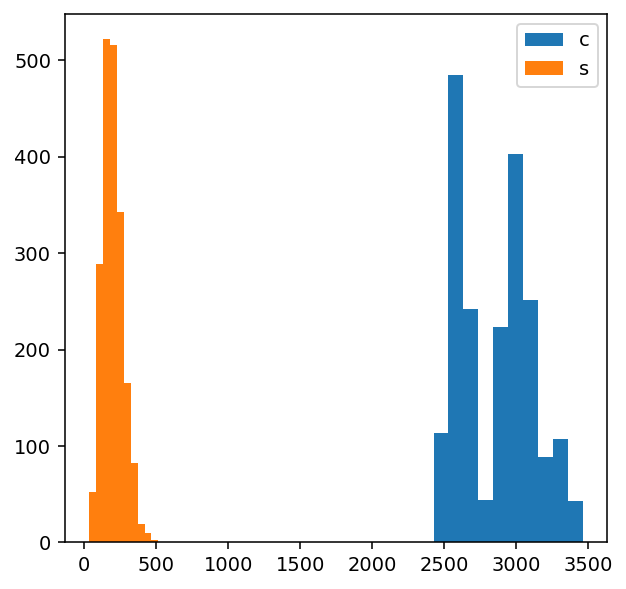

In [15]:
np.random.seed(42) # you may wan tto provide a seed to consistent results
X = sample_queries(N=2000)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.hist(X[:,0])
ax.hist(X[:,1])
ax.legend(('c','s'))


In [16]:
# Note this test only ensure that you you have sensible sampler
# - it is not absolute evidence 
# that your sampler is exactly as specified (you should make 
# extra sure to test your implementation)
#
# You sampler will be checked manually when marking against a more 
# extentive test and you marks are thus tentative!
#

with tick.marks(10):        
    query_function_is_likely_correct = False
    for irep in range(0,10): # repeat a few times to make it wasn't a lucky run
        for n in [100000]:
            samples = sample_queries(n)
            assert samples.shape == (n,2)
            assert np.min(samples[:,0]) > 0
            assert np.min(samples[:,1]) > 0            
            qc  = np.quantile(samples[:,0], np.linspace(0.1,0.95,10))
            qs  = np.quantile(samples[:,1], np.linspace(0.1,0.95,10))            
            qc_true = np.array([2559.81294538, 2598.13385305, 2635.78435576, 2701.46328125, 2906.86488528,
 2962.39459602, 3006.37913367, 3051.42630076, 3119.26061183, 3300.0165527 ])            
            qs_true =  np.array([116.1991005,  137.92636883, 155.6764329,  171.72291999, 187.65768372,
 204.21707941, 222.46446212, 244.37819637, 274.05809583, 328.05806855])            
            assert( np.all( np.abs(qc_true - qc) < 25 ))
            assert( np.all( np.abs(qs_true - qs) < 10 ))                
    
    query_function_is_likely_correct = True
    

In [17]:
# A placeholder for the automarker

#### Part 3.3 Execute a single query 
You must now complete a function which can execute a single query based on the start and end points of the interval, [a,b], against the database (in this case a Panda dataframe stored in the variable named ´data´)

The function must return:
- the time taken in seconds (already provided), t
- the cardinality of the result set, n
- the result set, i.e. all rows where $a=c-s/2 \leq Elevation \leq b=c+s/2$

***Hint***: You may need to consult the documentation for Panda to find a suitable command.

In [18]:
def query(a,b):    
    tic=timeit.default_timer()    
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    result_set = data[data["Elevation"].between(a,b,inclusive=True)]
    n = len(result_set)
    toc=timeit.default_timer() 
    t = toc - tic 
    return t, n, result_set          

In [19]:
with tick.marks(5): 
    query_function_is_correct = False
    t, n, res = query(2967.0,2967.5)
    z = np.sum(res['Aspect'].to_numpy())    
    assert( n == 762 )
    assert( z == 121183 )
    query_function_is_correct = True
    

#### Part 3.4 Execute and time all queries

You should now execute all the queries in `X` against the database by calling the function `query`. Queries should be read from the `X` array previously generated.

The resulting data should be collected in two numpy arrays:

- `y_times` with shape (2000,1) holding the times measured for each query
- `y_cardinality` with shape (2000,1) holding the size of the result set for each query


In [20]:
N = np.shape(X)[0]
y_times = np.zeros((N,1))
y_cardinality = np.zeros((N,1))

# Hint remember that you need to pass a and b to query (not c and s)
# YOUR CODE HERE
#raise NotImplementedError()
for i in range(0,N):
    c = X[i,0]
    s = X[i,1]
    a = c - s/2
    b = c + s/2
    t,n,result_set = query(a,b)
    y_times[i] = t
    y_cardinality[i] = n 

In [21]:
# Hidden test (make sure you test your function carefully!) [5 marks]


We can then plot the distribution of the cardinality measurements... Validate that the histogram looks like you expect.


Text(0.5, 1.0, 'Orginal')

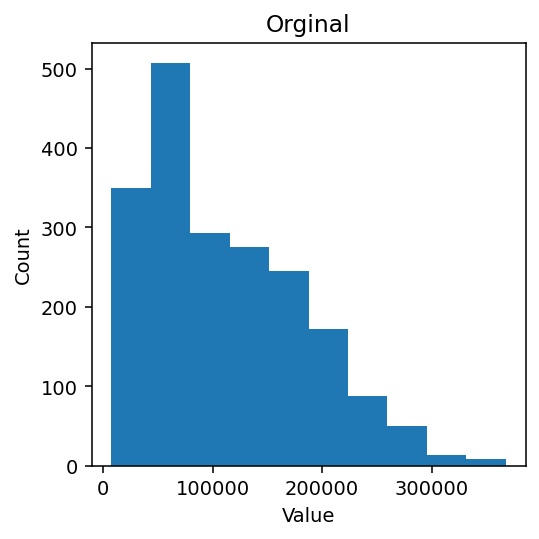

In [22]:
fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot(1,1,1) 
ax.hist(y_cardinality)
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax.set_title('Orginal')

#### Part 3.5 Save the data for later use (and for testing/validation )

In [23]:
np.savez('datalog.npz', X=X,y_times=y_times,y_cardinality=y_cardinality)

---

#### Part 3.6 Map from query to cardinality
We are now interested in specifying a function which can map from a query (i.e. x=[c,s]) to the query cardinality for this database (i.e the Panda dataframe).

The function is pre-defined as:: 

$$f(x;\theta ) = {w_0} + {w_1}c + {w_2}s + {w_3}{c^2} + {w_4}{s^2} + {w_5}{c^3} + {w_6}{s^3} + {w_7}{c^4} + {w_8}{s^4} + {w_9}\cdot c \cdot s \,\,\,\,\,\,\,\, (Eq. 3)$$

where x is a query which is mapped through f to the query cardinality. The loss defined as 

$$L\left( \theta  \right) = \frac{1}{N} \sum\limits_{n = 1}^{N=2000} {{{\left( { {y_n} - f({x_n};\theta )} \right)}^2}} $$

You should now complete four classes/methods that the database team use in their estimation:

- `output_process` 
- `input_process`
- `predict`
- `estimate`
- `evaluate`

**Hint**: It is recommend that you write the function in matrix form (use pen and paper) before attempting to implement it.

Any method you implement must be based on pure Python and numpy (i.e. **you cannot use scikit learn or similar tools**).


**Marking:** The overall marking is based on whether you manage to a) beat a baseline prediction, and b) come close to the correct solution. There are intermediate marks to help you along.



In [24]:
# Load the generated data from the file
# This makes it easier to mark and debug your solution at marking time
# Hint: If you struggle to generate meaningful data in the previous part you can 
# copy the content of the cell to a new cell and load the file called datalog_demo.npz 
# which contains pre-generated observations.

tmp = np.load('datalog.npz')
X = tmp['X']
y_cardinality = tmp['y_cardinality']

In [25]:
# A placeholder for the automarker

#### Part 3.7 Input and output processing
Complete the `input_process` class for preprocessing the inputs, X (e.g. normalisaiton and other transforms of X). 

- `output_process`: is already provided and you shouldn't need to modify it. 
- `input_process`: you probably need to inspect the other functions and cells below (e.g. predict) to work out what to put here.


In [26]:
class output_process:    
    """
    A simple helper class which containes two functions for removing the mean of y and 
    adding it at prediction time 
    
    Requirement: y = rescale(scale(y))    
                        
    
    """
    y_mean = None # these are just proposals, you can modify the variables function as you se fit depending on if and how you wish to 
    y_std = None
    
    def __init__(self, y):                
        self.y_mean = 0 # this is a trick, it is only 0 for now
        self.y_mean = np.mean(self.scale(y),axis=0)        
        
    def scale(self,y):        
        """
        A function which scales/tranforms the y values, e.g. subtracting the mean.
        """       
        y_prime = y - self.y_mean                
        return y_prime
    
    def rescale(self,y_prime):
        """
        A function which re-scales/tranforms the y_prime value back to the orginal domain (e.g. undoes the effect of scale)
        E.g., adding a constant such as the mean.
        
        """        
        y = y_prime + self.y_mean         
        y[y<0]=0  # avoid negative predictions          
        return y         
    

In [27]:
class input_process:   
    """    
    A simple class which contains two functions for processign the 2D observation of the query x=(c,s) 
    and returns a potentially scaled, normalised and expanded representation.                         
    """
    X_mean = None # proposal; the usage depends on you decision to normalise X or not    
    X_std  = None # proposal; the usage depends on you decision to standardise X or not    
        
    def __init__(self, X):         
        self.X_mean = 0 # this is a trick, it is only 0 for now
        self.X_std  = 1 # this is a trick, it is only 1 for now
        self.X_mean = np.mean(self.process(X)[:,1:] ,axis=0)                
        self.X_std  = np.std(self.process(X)[:,1:] ,axis=0)                
                    
    def process(self,X):
        """
        A function which takes the 2D in and processes the data, e.g. make a basis expansion and 
        standardise the result.
        
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        c = X[:,0]
        s = X[:,1]
        arr = []
        for i in range(0,len(c)):
            arr.append([1,c[i],s[i],c[i]**2,s[i]**2,c[i]**3,s[i]**3,c[i]**4,s[i]**4,c[i]*s[i]])
        
        arr = np.array(arr)
        dem_vec = np.std(arr[:,1:],axis=0)
        std_dev = arr[:,1:] - np.mean(arr[:,1:],axis =0)
        
        arr[:,1:] = dem_vec/std_dev
        
        return arr

##### Input process:

We can apply the input process to query and observe the effect. This is the tricky bit so make sure to validate that input_process works as intended (there are no automated test to check this!).

**Note**: If you have done this the recommend/intended way, the output would not be 2D for each observations but rather 10D.

In [28]:
inprocess = input_process(X)
x_demo = inprocess.process(X[0:3,:]) # take 3 queries and see what happens to them
print(x_demo)

[[  1.          -0.89458688 118.63312901  -0.89760935 -10.10060603
   -0.90065714  -4.99507284  -0.90372984  -3.43338987 -15.1065987 ]
 [  1.           0.76386008   0.81933067   0.76251721   0.78663229
    0.76119851   0.76189908   0.75990379   0.74398225   0.79586116]
 [  1.          -5.22723101  -0.81371084  -5.06648688  -0.85306906
   -4.91600149  -0.89902792  -4.77484927  -0.94979323  -0.84012128]]


#### Part 3.8 Predict 
Implement a function that can predict the cardinality, $y$, of a query $x=[c,s]$ based on Eq. (3). The parameters are stored in `theta` (i.e. $w \in \mathbb{R}^{10}$), using only linear algebra/vector operations and calls to the relevant input and output process functions (these are shown). 

The function should return the estimate of the cardinality in $y$, and the scale prediction in y_prime. It must be able to make predictions for multiple observations in `X` (i.e. `X` is a matrix).

In [29]:
def predict(X, theta, output_process,input_process):      
    if input_process is not None: # note we use None when testing/marking
        X = input_process.process(X)
    
    # Hint: Only a single line of code is missing
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    y_prime = np.dot(X, theta)
    if output_process is not None: # note we use None when testing/marking
        y = output_process.rescale(y_prime)
    else:
        y = y_prime
        
    return y, y_prime

In [30]:
# Hidden test validating the predict function [5 Marks]
# Test which test the core functionality of the predict function (it doesn't test the input and output process)

with tick.marks(5):
    X_test = np.array([[1.2,8.54],[2.4,4.5]])
    theta = np.array([0.50722768, -1.32649421])
    y_test, y_prime_test = predict(X_test, theta, None, None)
        
    assert(check_hash(y_test, ((2,), -48.182417152)))
    assert(check_hash(y_prime_test, ((2,), -48.182417152)))    
    

#### Part 3.9
Write a function which computes the mean squared error (mse) based on the difference between the predicted and true query cardinality. It should also return the mean absolute error and the relative absolute error (in percent) wrt to the actual observation for the absolute error (i.e. how many percent is the prediction wrong on average).




In [31]:
def evaluate(y_pred,y_true):
    # YOUR CODE HERE
    #raise NotImplementedError()
    error_mse = np.mean((y_true-y_pred)**2)
    error_abs = np.mean(np.abs(y_true-y_pred))
    error_abs_relative = np.mean((np.absolute(y_true-y_pred)/y_true)*100)
    return error_mse, error_abs, error_abs_relative

In [32]:
# Test checkign the evaluate function
with tick.marks(5):
    a,b,c = evaluate(np.array([4.5,6.2,-100.10]), np.array([14.5,-26.2,-110.10]))    
    assert(check_hash(a, ((), 2082.9333333333334)))
    assert(check_hash(b, ((), 87.33333333333333)))
    assert(check_hash(c, ((), -106.30209505074754)))      

#### Part 3.10
Implement a function which estimates the parameters, i.e., the $w$'s stored in `theta`, of the function based on the squared error loss defined above.

Hint: This should be done using only matrix operations and calls to the input/output process functions. You don't need numerical optimisation for this.


In [33]:
def estimate(X, y, outprocess, inprocess):
    """
    X: 2D queries/observations 
    y: observed cardinality (the orginal ones, i.e. not scaled or normalised) 
    outprocess: an instance of the output process class which is used to scale and rescale y
    inprocess: an instance of the input process class which is used to process the 2D input in X in a sensible way
    """        
    if outprocess is not None: # note we use None when testing/marking
        y = outprocess.scale(y)
        
    if inprocess is not None: # note we use None when testing/marking
        X = inprocess.process(X)
    
    # Hint: 2-3 lines of code missing
    # YOUR CODE HERE
    #raise NotImplementedError()
    inv = np.linalg.pinv(X)
    theta = inv @ y
    return theta

In [34]:
# Hidden test validating the estimate function[5 MARKS]
with tick.marks(7):
    X_test = np.array([[1.2,8.54,9.77],[2.4,4.5,-33.2]])
    y_yest = np.array([1,2])    
    theta_test = estimate(X_test, y_yest, None, None)
    assert(check_hash(theta_test, ((3,), 0.5095082848719855)))


#### Part 3.11

We can now put it all together and check if we are able to make sensible fit to the data.

Note: It might be necessary to revisit your implementation above in case you do not get a sensible fit in the first attempt.


In [35]:
inprocess = input_process(X)
outprocess = output_process(y_cardinality)
theta = estimate(X,y_cardinality,outprocess,inprocess)
y_pred, y_prime_pred = predict(X, theta, outprocess,inprocess)
error_mse, error_abs, error_abs_rel = evaluate(y_pred,y_cardinality)

print("The mse error is: ", error_mse)
print("The abs error is: ", error_abs)
print("The releative abs error is [pct]: ", error_abs_rel)

The mse error is:  4888675193.173182
The abs error is:  58456.828352256474
The releative abs error is [pct]:  88.36836749114482


#### Part 3.12

To evaluate the quality of your fit it is often useful to produce visualisation to aid our analysis. For this purpose you should now:

- Create a plot of the cardinality vs the ones estimated by the model. Include a line to illustrate the ideal prediction.
- Create a figure showing the distribution of errors
- Create a figure visualising the squared error against the the query cardinality 


Note: These are not assessed per se but suggested for your benefit. They will be written to the pdf file and inspected manually.

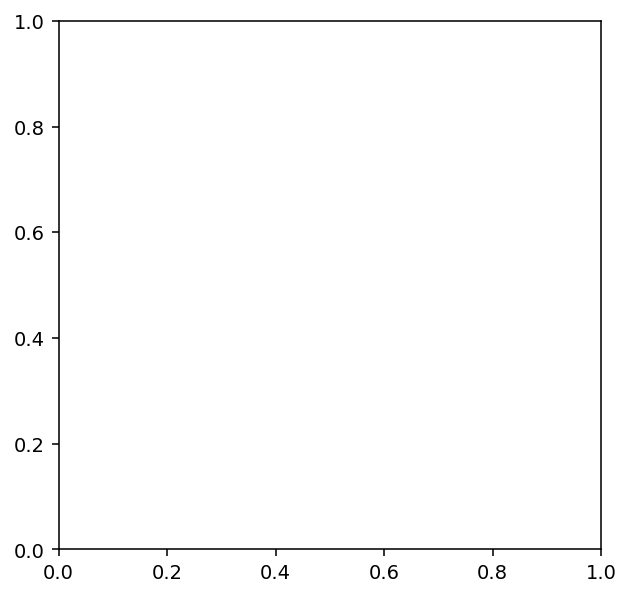

In [36]:
fig_312a = plt.figure(figsize=(5,5)) # DO NOT CHANGE
ax_312a = fig_312a.add_subplot() # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################
# YOUR CODE HERE
#plt.plot(y_cardinality,regressor.predict(X_train),color='blue')
#raise NotImplementedError()

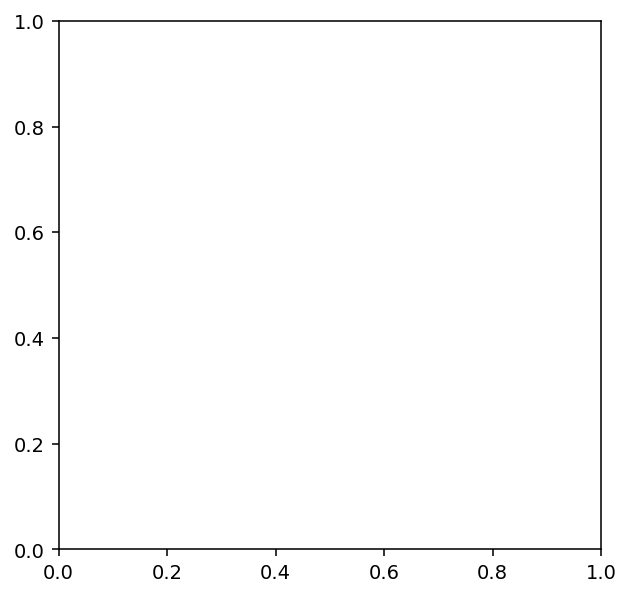

In [37]:
fig_312b = plt.figure(figsize=(5,5)) # DO NOT CHANGE
ax_312b = fig_312b.add_subplot(1,1,1) # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################
# YOUR CODE HERE
#raise NotImplementedError()

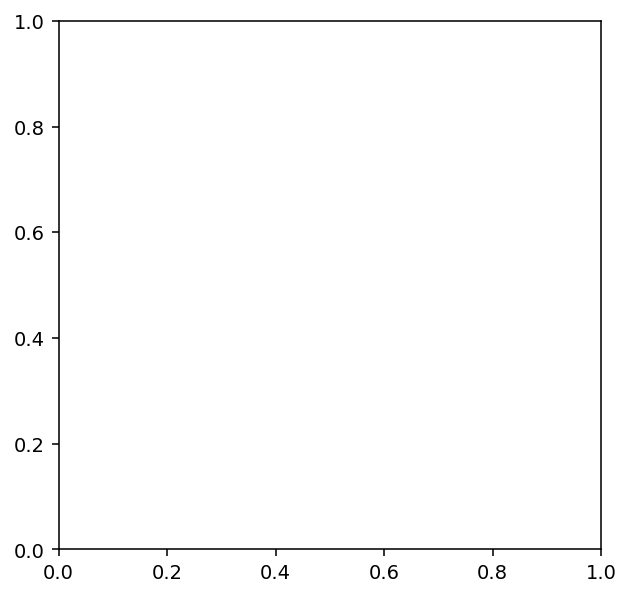

In [38]:
fig_312c = plt.figure(figsize=(5,5)) # DO NOT CHANGE
ax_312c = fig_312c.add_subplot(1,1,1) # DO NOT CHANGE - YOU MUST ADD YOUR FIGURE TO THIS AXIS
#######################################################

# YOUR CODE HERE
#raise NotImplementedError()

#### Part 3.13 Baselines
To determine if your model is worth deploying and using for estimating the database load, your database team has requested you compare your function/fit to a naiive baseline.


The two baseline are:
- a) use the mean of the observations as the prediction for all queries 
- b) use the median of the observation as the prediction for all queries.   

Complete the `predict_average` and `predict_median` function below and compare with your predictive model.


In [39]:
def predict_mean(y):    
    """ 
        Take observations y as input a return a scalar with the mean which is used for the prediction for all queries
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    y_mean = np.mean(y)
    return y_mean

def predict_average(y):    
    """ 
        Take observations y as input a return a scalar with the mean which is used for the prediction for all queries
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    y_mean = np.mean(y)
    return y_mean

In [40]:
def predict_median(y):    
    """Take observations y as input a return a scalar with the meadian which is used for the prediction for all input queries"""
    # YOUR CODE HERE
    #raise NotImplementedError()
    y_median = np.median(y)
    return y_median

In [41]:
# Check that the baselines work as expected
with tick.marks(4):
    baseline_is_corrrect= False
    y_test = np.array([-3.4, 3, 6.2, 10])
    y_test_avg = predict_mean(y_test)    
    y_test_median = predict_median(y_test)
    assert(check_hash(y_test_avg, ((), 19.75)))
    assert(check_hash(y_test_median, ((), 23.0)))
    baseline_is_corrrect = True
    

In [42]:
# Evaluate the baselines

y_pred_blavg = predict_average(y_cardinality)
error_mse_blavg, error_abs_blavg, error_abs_rel_blavg = evaluate(y_pred_blavg,y_cardinality)

print("Mean (or average) baseline:")
print("The mse error for the avg baseline is: ", error_mse_blavg)
print("The abs error for the avg baseline is: ", error_abs_blavg)
print("The relative abs error for the avg baseline is [pct]: ", error_abs_rel_blavg)

print("\nMedian baseline:")
y_pred_blmed = predict_median(y_cardinality)
error_mse_blmed, error_abs_blmed, error_abs_rel_blmed = evaluate(y_pred_blmed,y_cardinality)
print("The mse error for the median baseline is: ", error_mse_blmed)
print("The abs error for the median baseline is: ", error_abs_blmed)
print("The relative abs error for the median baseline is [pct]: ", error_abs_rel_blmed)


Mean (or average) baseline:
The mse error for the avg baseline is:  5016902431.878307
The abs error for the avg baseline is:  59481.918393
The relative abs error for the avg baseline is [pct]:  90.30818907604284

Median baseline:
The mse error for the median baseline is:  5221322553.749
The abs error for the median baseline is:  58515.8055
The relative abs error for the median baseline is [pct]:  77.97455583663037


Overall marking of your function...

In [43]:
# Hidden test, you get 5 marks for beating the median baseline (the baseline needs to be correct for any marks)

In [44]:
## Hidden test, you'll get a TOTAL of 18 marks for obtaining a competetive performance close to our implementation 
# You'd need to manually validate that you have obtained a sensible and competetive solution.




#### No more assessed questions... remember to generate the pdf!


### Part 3.X: Optional challenges
Several improvements could be considered for the function/implementation in Part 3:
- The function we have specified in Eq. (3) is unlikely to be the best option for this purpose. You may want to try the neural network we implemented in Lab 2 - or perhaps other variations of the function suggested. 
- The cardinality is an integer, but our prediction function does not take that into account (we could consider ordinal regression). 
- We handle the negative predictions by truncating the predictions; ideally, this should be inherent to the model (i.e., via the loss function).
- The function we have fitted probably only works well for the specific query dataset; we should test it on an unseen query dataset - or at least held-out-queries from the current dataset - to make sure it generalizes.
- Can you also predict the query time using this approach?
- ...

We would be happy to look over notebooks addressing these issues, but you will not get extra credit.

-----

# Submission on Moodle


We will generate the **one** pdf file you'll need to submit **along** with the notebook. **DO NOT RENAME THE FILES!**

*Note*: you do not need to worry about the formatting etc (that's predetermined)


In [45]:
## Report generation - YOU MUST YOU RUN THIS CELL !
#
# Ignore warnings regarding fonts
#
from matplotlib.backends.backend_pdf import PdfPages

# Declaration of originality with system info
try:
    f = open('uofg_declaration_of_originality.txt','r')
    uofg_declaration_of_originality = f.read()
except: 
    uofg_declaration_of_originality = "uofg_declaration_of_originality not present in cwd"

try:
    student_id.lower()
except: 
    student_id="NORESPONSE"
try:
    student_typewritten_signature.lower()
except: 
    student_typewritten_signature="NORESPONSE"

fn = ("idss_lab_04_dsinpractice_%s_declaration.pdf" % (student_id.lower()))
fig_dec = plt.figure(figsize=(10, 12)) 
fig_dec.text(0.1,0.1,("%s\n\n Student Id %s\n\n Typewritten signature: %s\n\n UUID System: %s" % (uofg_declaration_of_originality,student_id, student_typewritten_signature, uuid_system)))
    
# Combined: 
fn = ("idss_lab_04_dsinpractice_%s_combined_v20212022a.pdf" % (student_id))
pp = PdfPages(fn)
pp.savefig(fig_312a)
pp.savefig(fig_312b)
pp.savefig(fig_312c)
pp.savefig(fig_dec)
pp.close()

with tick.marks(0):  # have you generated the combined file...? you don't actually get any credit for this; just confirmation that the file has been generated
    assert(os.path.exists(fn))

<Figure size 1400x1680 with 0 Axes>

**You must (for full or partial marks) submit TWO files via Moodle:**

- this notebook (completed) after "Restart and rerun all":
    - `idss_lab_04_dsinpractice_v20212022a.ipynb`
    
- the combined pdf (autogenerated) containing the relevant figures and answers for the manual marking:
     - `idss_lab_04_dsinpractice_[YOUR STUDENT ID]_combined_v20212022a.pdf`)     
    


---

# Appendix: Marking Summary (and other metadata)
#### - make sure the notebook runs without errors (remove/resolve the `raise NotImplementedError()`) and "Restart and Rerun All" cells to get a correct indication of your marks.

In [46]:
print("Marks total : ","100")
print("Marks visible (with immediate feedback): ","50")
print("Marks hidden (without immediate feedback): ","50")
print("\nThe fraction below displays your performance on the autograded part of the lab that's visible with feedback (only valid after `Restart and Run all`:")
tick.summarise_marks() # 

Marks total :  100
Marks visible (with immediate feedback):  50
Marks hidden (without immediate feedback):  50

The fraction below displays your performance on the autograded part of the lab that's visible with feedback (only valid after `Restart and Run all`:


---